We work for a credit card company and we've been tasked with segmenting the customers of a dataset into groups in order apply different business strategies for each type of customer.

Luckily, the data engineering team has cleaned most of the data so we can focus on building the best possible model to segment the data.

As per the Data Science coordinator, we should use the K-means algorithm to segment the data. We're expected to to deliver a group for each client, along with an explanation of the characteristics of each group and the main points that make them different.

We'll be going through the following steps to achieve the goals the company has set for us:
- Analyze the dataset;
- Prepare the data for modeling;
- Find an appropriate number of clusters;
- Segment the data;
- Interpret and explain the results

Here's the data dictionary:

customer_id: unique identifier for each customer.
age: customer age in years.
gender: customer gender (M or F).
dependent_count: number of dependents of each customer.
education_level: level of education ("High School", "Graduate", etc.).
marital_status: marital status ("Single", "Married", etc.).
estimated_income: the estimated income for the customer projected by the data science team.
months_on_book: time as a customer in months.
total_relationship_count: number of times the customer contacted the company.
months_inactive_12_mon: number of months the customer did not use the credit card in the last 12 months.
credit_limit: customer's credit limit.
total_trans_amount: the overall amount of money spent on the card by the customer.
total_trans_count: the overall number of times the customer used the card.
avg_utilization_ratio: daily average utilization ratio.

Let's explore the data

## Exploratory Data Analysis

In [19]:
#import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

sns.set_style('whitegrid')


In [7]:
customers = pd.read_csv('customer_segmentation.csv')
customers.head()

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000
3,769911858,40,F,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760
4,709106358,40,M,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000


In [9]:
customers.shape

(10127, 14)

In [10]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10127 non-null  int64  
 1   age                       10127 non-null  int64  
 2   gender                    10127 non-null  object 
 3   dependent_count           10127 non-null  int64  
 4   education_level           10127 non-null  object 
 5   marital_status            10127 non-null  object 
 6   estimated_income          10127 non-null  int64  
 7   months_on_book            10127 non-null  int64  
 8   total_relationship_count  10127 non-null  int64  
 9   months_inactive_12_mon    10127 non-null  int64  
 10  credit_limit              10127 non-null  float64
 11  total_trans_amount        10127 non-null  int64  
 12  total_trans_count         10127 non-null  int64  
 13  avg_utilization_ratio     10127 non-null  float64
dtypes: flo

In [5]:
customers.describe()

,customer_id,age,dependent_count,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
count,1.012700e+04,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,7.391776e+08,46.325960,2.346203,62078.206774,35.928409,3.812580,2.341167,8631.953698,4404.086304,64.858695,0.274894
std,3.690378e+07,8.016814,1.298908,39372.861291,7.986416,1.554408,1.010622,9088.776650,3397.129254,23.472570,0.275691
min,7.080821e+08,26.000000,0.000000,20000.000000,13.000000,1.000000,0.000000,1438.300000,510.000000,10.000000,0.000000
25%,7.130368e+08,41.000000,1.000000,32000.000000,31.000000,3.000000,2.000000,2555.000000,2155.500000,45.000000,0.023000
50%,7.179264e+08,46.000000,2.000000,50000.000000,36.000000,4.000000,2.000000,4549.000000,3899.000000,67.000000,0.176000
75%,7.731435e+08,52.000000,3.000000,80000.000000,40.000000,5.000000,3.000000,11067.500000,4741.000000,81.000000,0.503000
max,8.283431e+08,73.000000,5.000000,200000.000000,56.000000,6.000000,6.000000,34516.000000,18484.000000,139.000000,0.999000


A preliminary assessment on some of the points on the dataset:

- There are 10127 rows and 14 columns in the dataset 
- Theres one column that houses a unique identifier for each client. This wont be  needed for the segmentation.
- Of the other 13 columns...
  - 8 columns contain integers
  - 2 contain floats
  - 3 columns contain strings
  - 3 categorical columns
- There no missing values

In [13]:
for col in ['gender', 'education_level', 'marital_status']:
    print(customers[col].value_counts(), end='\n\n')

gender
F    5358
M    4769
Name: count, dtype: int64

education_level
Graduate         3685
High School      2351
Uneducated       1755
College          1192
Post-Graduate     616
Doctorate         528
Name: count, dtype: int64

marital_status
Married     4687
Single      3943
Unknown      749
Divorced     748
Name: count, dtype: int64



In [14]:
for col in ['gender', 'education_level', 'marital_status']:
    print(customers[col].value_counts(normalize=True), end='\n\n')

gender
F    0.529081
M    0.470919
Name: proportion, dtype: float64

education_level
Graduate         0.363879
High School      0.232152
Uneducated       0.173299
College          0.117705
Post-Graduate    0.060827
Doctorate        0.052138
Name: proportion, dtype: float64

marital_status
Married     0.462822
Single      0.389355
Unknown     0.073961
Divorced    0.073862
Name: proportion, dtype: float64



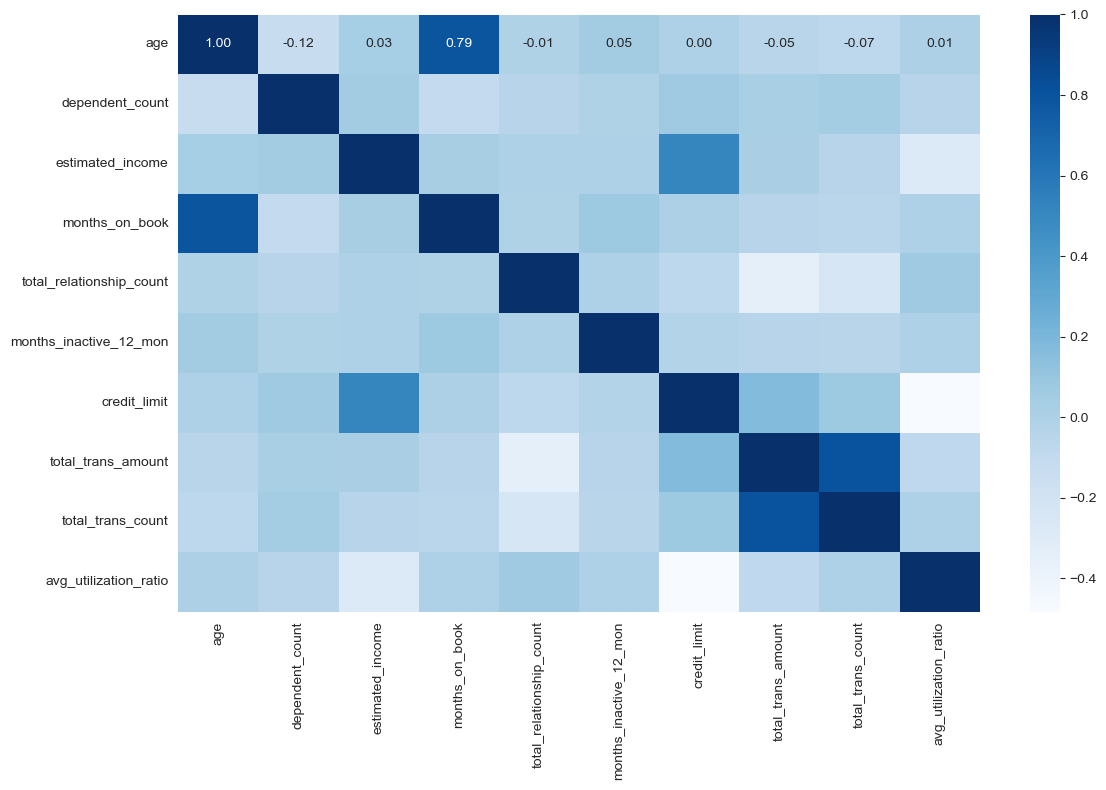

In [48]:
numerics = ['age', 'dependent_count', 'estimated_income', 'months_on_book', 'total_relationship_count', 'months_inactive_12_mon', 'credit_limit', 'total_trans_amount',	'total_trans_count', 'avg_utilization_ratio']
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(customers[numerics].corr(), fmt=".2f", annot=True, cmap='Blues', ax=ax, mask=False)
plt.tight_layout()
plt.show()

C:\Users\cisco\AppData\Local\Temp\ipykernel_13484\3527844798.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  customers.drop('customer_id', axis=1).hist(ax=ax)


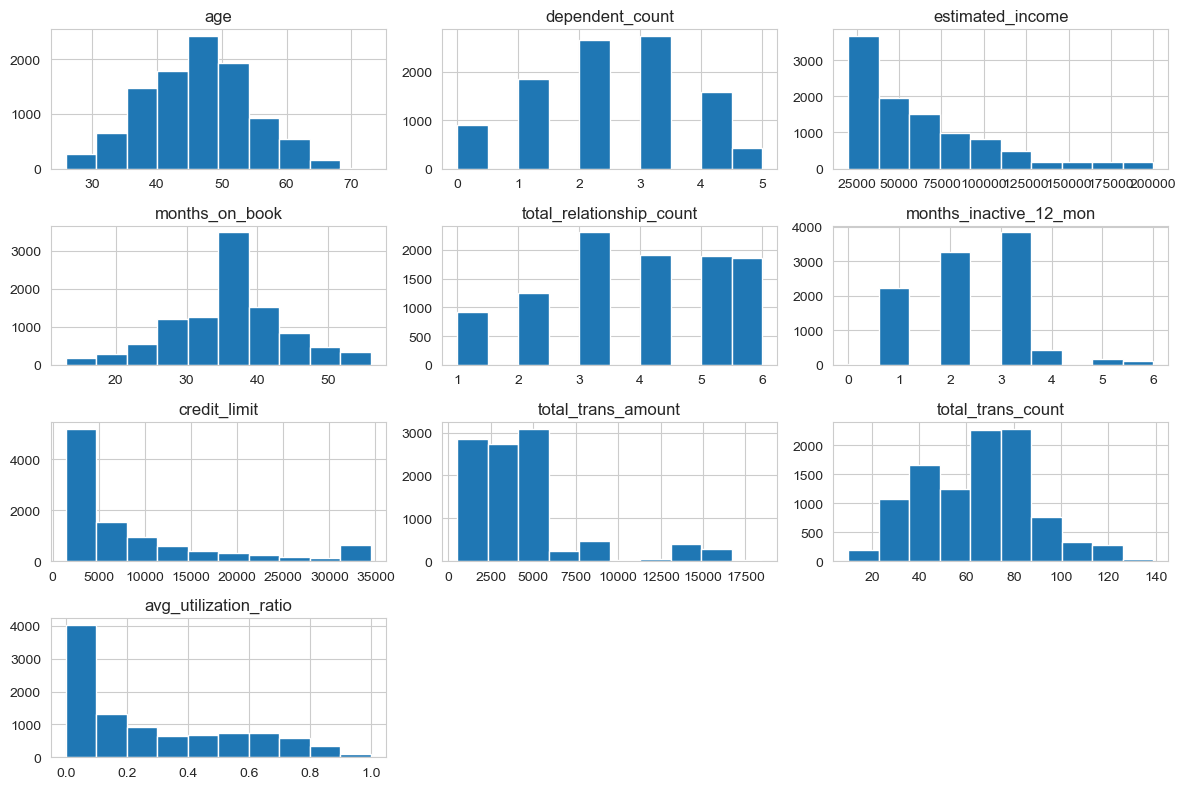

In [42]:
#plotting the distributions of each column
fig, ax = plt.subplots(figsize=(12,8))
customers.drop('customer_id', axis=1).hist(ax=ax)
plt.tight_layout()
plt.show()

## Feature Engineering

We'll work on dealing with the categorical columns

In [76]:
customers_modif = customers.copy()

In [77]:
customers_modif['gender'] = customers_modif['gender'].map({'M': 1, 'F': 0})
customers_modif['gender'].value_counts()

gender
0    5358
1    4769
Name: count, dtype: int64

In [79]:
edu_map = {'Uneducated': 0, 'High School': 1, 'College': 2, 'Graduate' : 3, 'Post-Graduate' : 4, 'Doctorate' : 5}
customers_modif['education_level'] = customers_modif['education_level'].map(edu_map)
customers_modif['education_level'].value_counts()

education_level
3    3685
1    2351
0    1755
2    1192
4     616
5     528
Name: count, dtype: int64

Seeing as there is no level of magnitude between different marital status, we can't implement a similar method to it as we did with education level.

Instead, we'll have to implement one-hot encoding to create dummy variables form this column.

In [81]:
#dummy variables for marital status
dummies = pd.get_dummies(customers_modif[['marital_status']], drop_first=True)
customers_modif = pd.concat([customers_modif, dummies], axis=1)
customers_modif.drop(['marital_status'], axis=1, inplace=True)

print(customers_modif.shape)
customers_modif.head()

(10127, 16)


,customer_id,age,gender,dependent_count,education_level,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,marital_status_Married,marital_status_Single,marital_status_Unknown
0,768805383,45,1,3,1,69000,39,5,1,12691.0,1144,42,0.061,True,False,False
1,818770008,49,0,5,3,24000,44,6,1,8256.0,1291,33,0.105,False,True,False
2,713982108,51,1,3,3,93000,36,4,1,3418.0,1887,20,0.000,True,False,False
3,769911858,40,0,4,1,37000,34,3,4,3313.0,1171,20,0.760,False,False,True
4,709106358,40,1,3,0,65000,21,5,1,4716.0,816,28,0.000,True,False,False


## Scaling the Data
We have different scaled dta across the dataframe, which could represent challenges down the line.

Let's transform the data so it's all on the same scale.

In [83]:
X = customers_modif.drop('customer_id', axis=1)
scaler = StandardScaler()
scaler.fit(X)

X_scaled = scaler.transform(X)
X_scaled[:5]

array([[-0.16540558,  1.05995565,  0.50336813, -0.75221102,  0.1758098 ,
         0.38462088,  0.76394261, -1.32713603,  0.4466219 , -0.95970657,
        -0.97389518, -0.77588223,  1.07733799, -0.79850685, -0.28260887],
       [ 0.33357038, -0.9434357 ,  2.04319867,  0.66278684, -0.96716585,
         1.01071482,  1.40730617, -1.32713603, -0.04136665, -0.91643261,
        -1.35734038, -0.61627565, -0.92821381,  1.2523374 , -0.28260887],
       [ 0.58305837,  1.05995565,  0.50336813,  0.66278684,  0.78539682,
         0.00896451,  0.12057905, -1.32713603, -0.5736978 , -0.74098169,
        -1.91120566, -0.99715499,  1.07733799, -0.79850685, -0.28260887],
       [-0.78912553, -0.9434357 ,  1.2732834 , -0.75221102, -0.63697289,
        -0.24147306, -0.52278451,  1.64147829, -0.58525108, -0.95175829,
        -1.91120566,  1.75968594, -0.92821381, -0.79850685,  3.53845931],
       [-0.78912553,  1.05995565,  0.50336813, -1.45970995,  0.07421197,
        -1.86931731,  0.76394261, -1.32713603, 

## Choosing K
Our dataset is ready for machine learning. What we need to decide is the best number of cluster to use in the segmentation according to the inertia metric.

We'll create several models, compute their inertias, and plot the Elbow Curve. From there, we'll be decide the number of clusters we'll use to segment the customers.

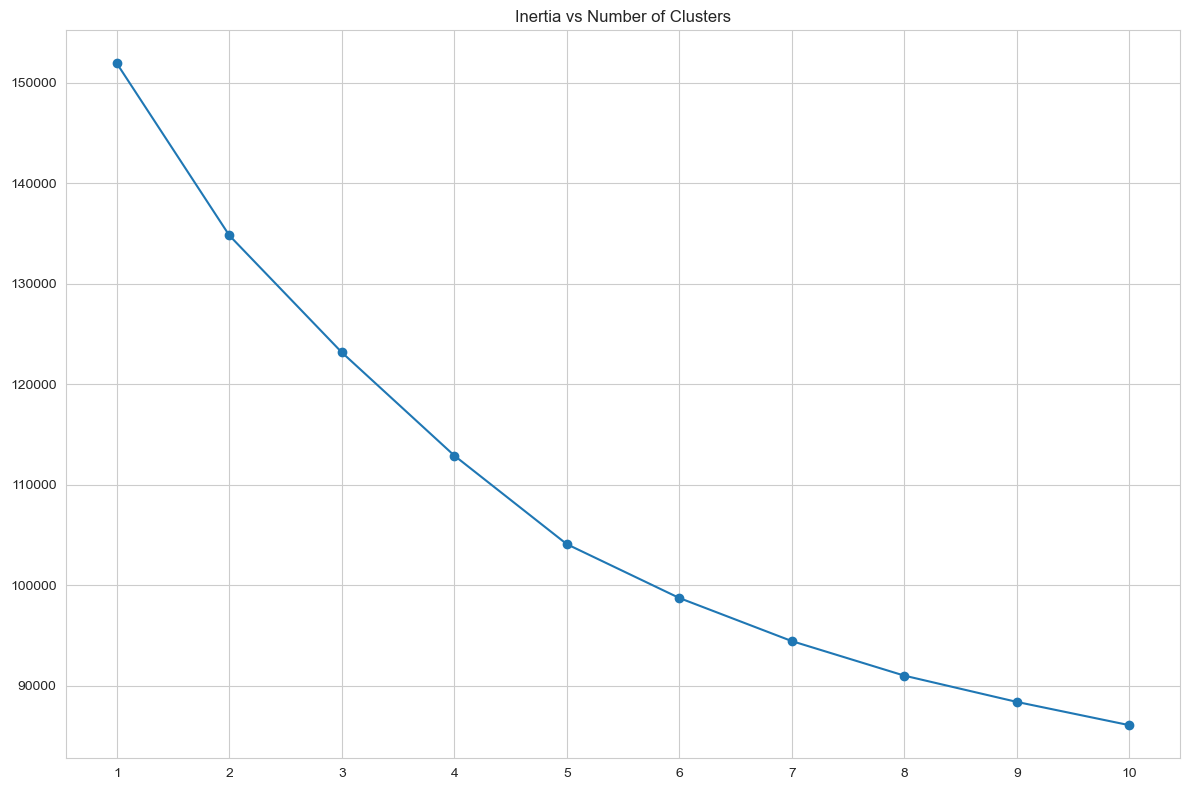

In [91]:
X = pd.DataFrame(X_scaled)

inertias = []

for k in range(1,11):
    model = KMeans(n_clusters=k, n_init=10)
    y = model.fit_predict(X, )
    inertias.append(model.inertia_)

plt.figure(figsize=(12,8))
plt.plot(range(1,11), inertias, marker='o')
plt.xticks(ticks=range(1, 11), labels=range(1, 11))
plt.title('Inertia vs Number of Clusters')
plt.tight_layout()
plt.show()

In [92]:
model = KMeans(n_clusters=6)
y = model.fit_predict(X_scaled)

y

c:\Users\cisco\anaconda3\envs\env_3_10_8\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([2, 0, 2, ..., 4, 3, 4])

In [93]:
customers['CLUSTER'] = y + 1
customers

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,CLUSTER
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061,3
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105,1
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000,3
3,769911858,40,F,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760,4
4,709106358,40,M,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,50,M,2,Graduate,Single,51000,40,3,2,4003.0,15476,117,0.462,6
10123,710638233,41,M,2,Graduate,Divorced,40000,25,4,2,4277.0,8764,69,0.511,5
10124,716506083,44,F,1,High School,Married,33000,36,5,3,5409.0,10291,60,0.000,5
10125,717406983,30,M,2,Graduate,Unknown,47000,36,4,3,5281.0,8395,62,0.000,4


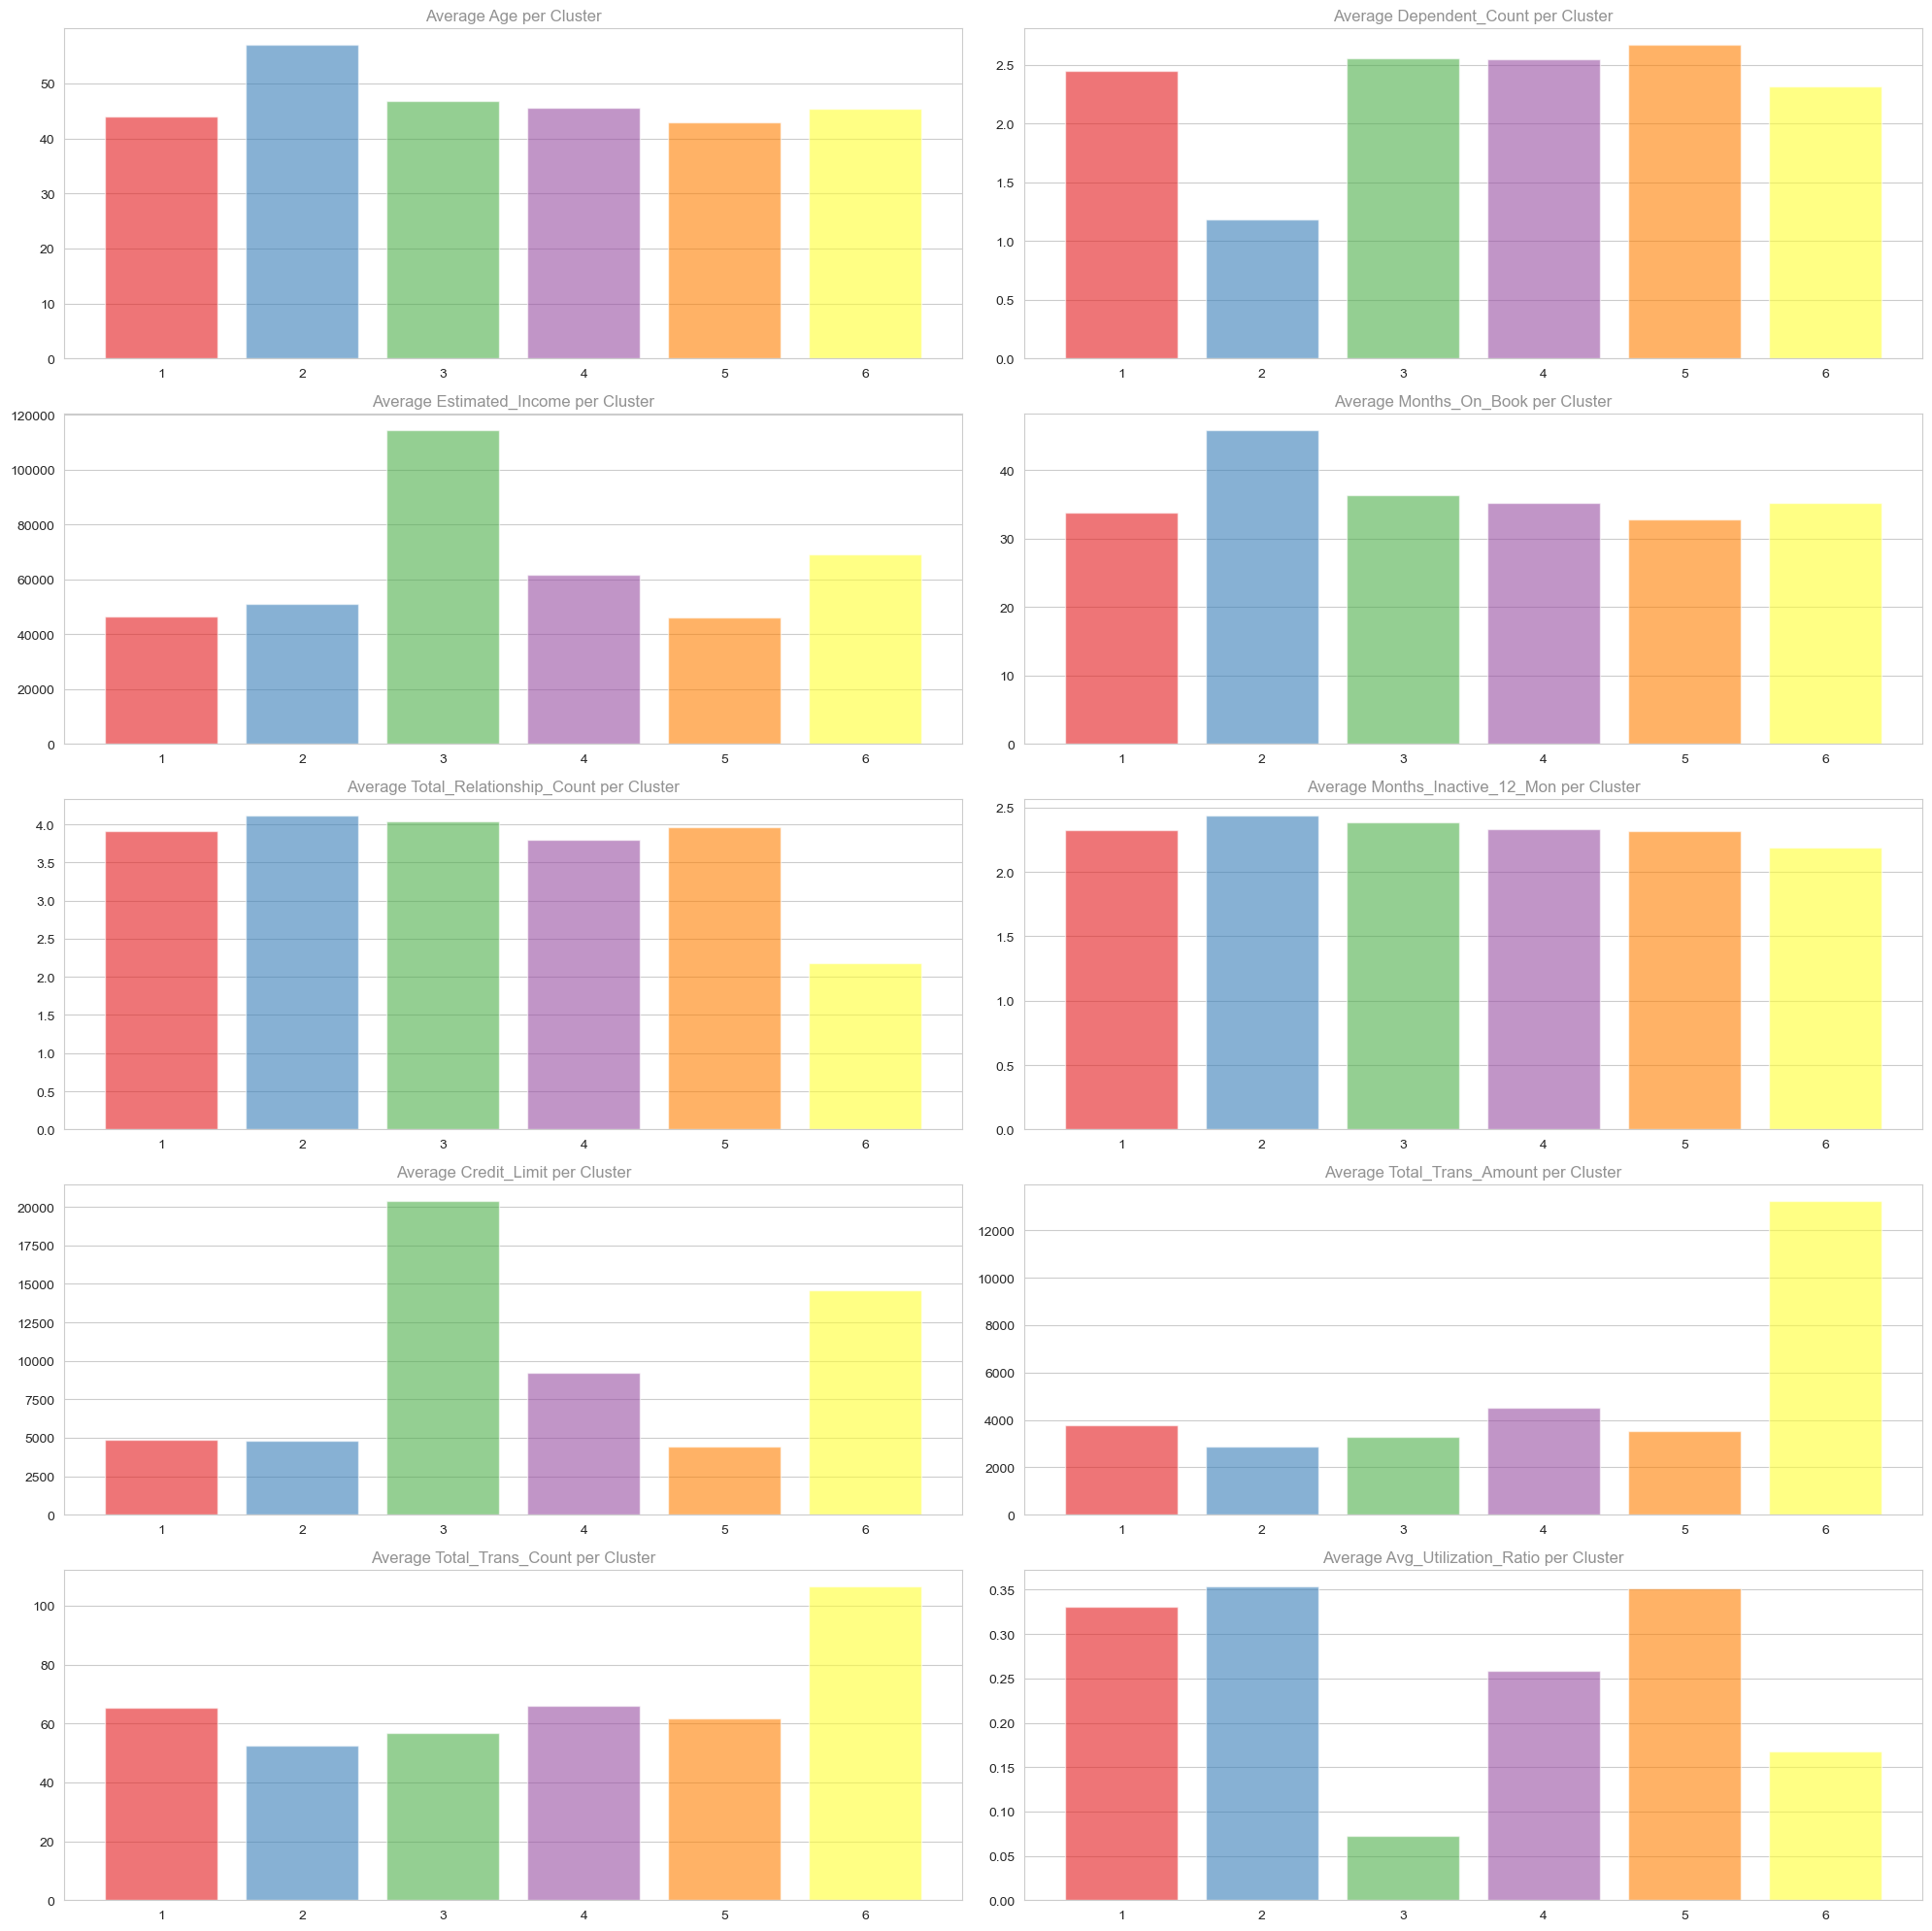

In [96]:
numerics = customers.select_dtypes(include=np.number).drop(['customer_id', 'CLUSTER'], axis=1).columns
fig = plt.figure(figsize=(20, 20))
for i, col in enumerate(numerics):
    df_plot = customers.groupby('CLUSTER')[col].mean()
    ax = fig.add_subplot(5, 2, i+1)
    ax.bar(df_plot.index, df_plot, color=sns.color_palette('Set1'), alpha=0.6)
    ax.set_title(f'Average {col.title()} per Cluster', alpha=0.5)
    ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

c:\Users\cisco\anaconda3\envs\env_3_10_8\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\cisco\anaconda3\envs\env_3_10_8\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\cisco\anaconda3\envs\env_3_10_8\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\cisco\anaconda3\envs\env_3_10_8\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

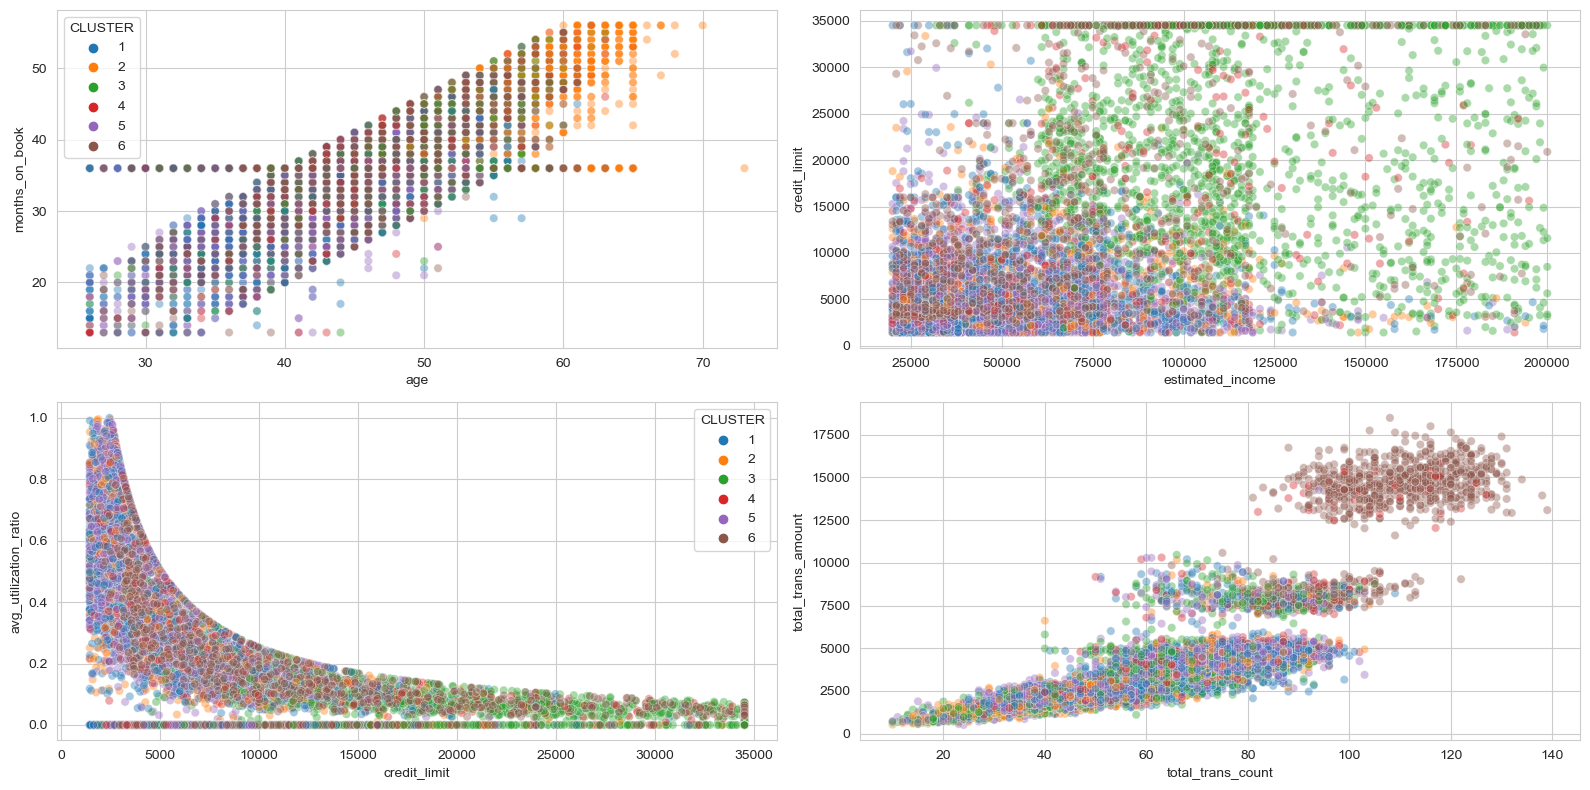

In [97]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 8))
sns.scatterplot(x='age', y='months_on_book', hue='CLUSTER', data=customers, palette='tab10', alpha=0.4, ax=ax1)
sns.scatterplot(x='estimated_income', y='credit_limit', hue='CLUSTER', data=customers, palette='tab10', alpha=0.4, ax=ax2, legend=False)
sns.scatterplot(x='credit_limit', y='avg_utilization_ratio', hue='CLUSTER', data=customers, palette='tab10', alpha=0.4, ax=ax3)
sns.scatterplot(x='total_trans_count', y='total_trans_amount', hue='CLUSTER', data=customers, palette='tab10', alpha=0.4, ax=ax4, legend=False)

plt.tight_layout()
plt.show()

C:\Users\cisco\AppData\Local\Temp\ipykernel_13484\906250918.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)
C:\Users\cisco\AppData\Local\Temp\ipykernel_13484\906250918.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)
C:\Users\cisco\AppData\Local\Temp\ipykernel_13484\906250918.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)


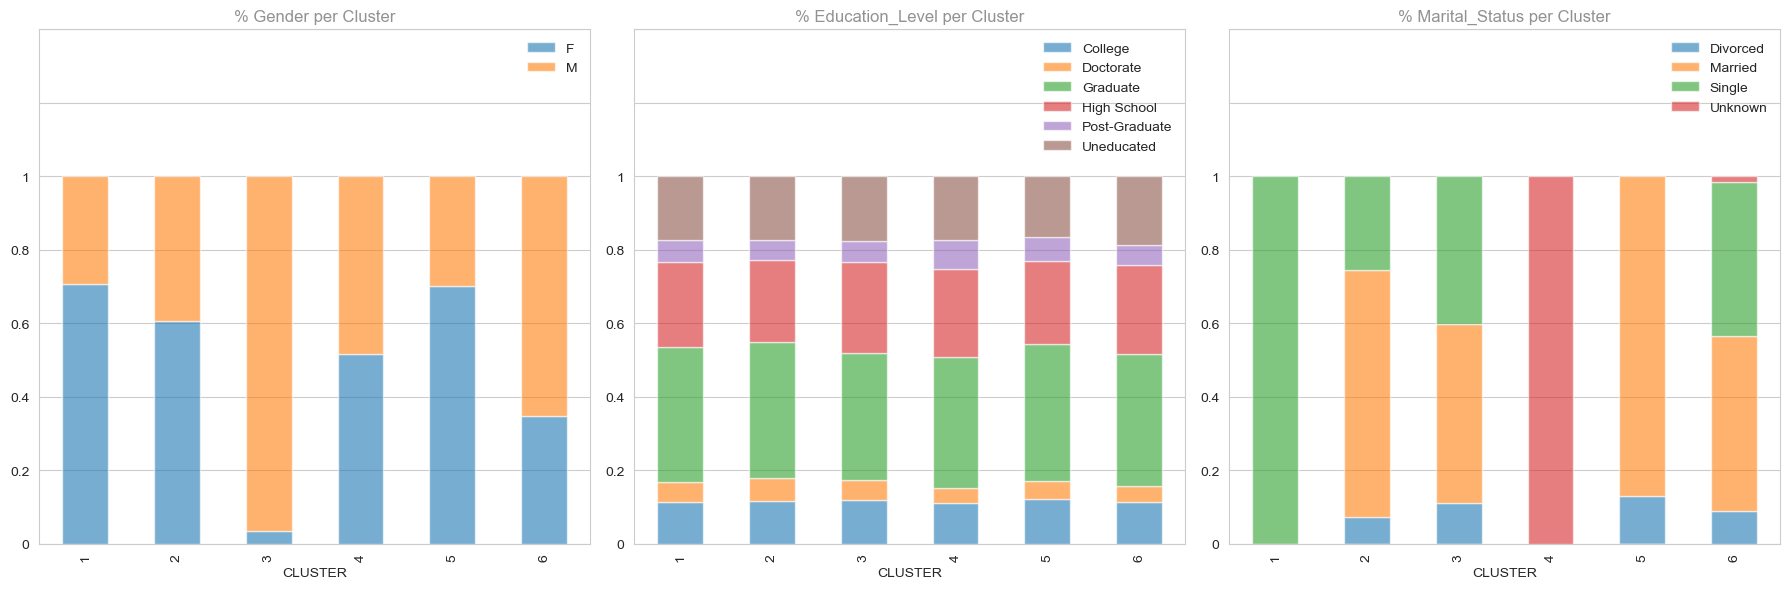

In [98]:
cat_columns = customers.select_dtypes(include=['object'])

fig = plt.figure(figsize=(18, 6))
for i, col in enumerate(cat_columns):
    plot_df = pd.crosstab(index=customers['CLUSTER'], columns=customers[col], values=customers[col], aggfunc='size', normalize='index')
    ax = fig.add_subplot(1, 3, i+1)
    plot_df.plot.bar(stacked=True, ax=ax, alpha=0.6)
    ax.set_title(f'% {col.title()} per Cluster', alpha=0.5)

    ax.set_ylim(0, 1.4)
    ax.legend(frameon=False)
    ax.xaxis.grid(False)
    
    labels = [0, 0.2, 0.4, 0.6, 0.8, 1]
    ax.set_yticklabels(labels)

plt.tight_layout()
plt.show()